In [ ]:
import numpy as np
import torch.optim as optim

In [ ]:
import numpy as np

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.mat_pre=mat_pre
        self.mat_post=mat_post
        self.mat=self.mat_post-self.mat_pre
        self.m=m0

    def is_tansition(self):
        self.tran=(self.m[:,None]>=self.mat_pre).all(0).nonzero()[0]   
        return  np.where(len(self.tran),True,False)  

    def firing(self,T):
        self.m=self.m+self.mat[:,T]     


mat_pre = np.loadtxt("D:\\petri_learning\\c.pre.txt")
mat_post = np.loadtxt("D:\\petri_learning\\c.post.txt")
m0 = np.loadtxt("D:\\petri_learning\\m0.txt") 
petri_net=Petri_net(mat_pre,mat_post,m0)  
print(petri_net.mat) 
print("初始标识：",petri_net.m)
for x in range(3):
    if petri_net.is_tansition():  #判断是否存在可激发变迁
        tran_enable=np.random.choice(petri_net.tran)  #随机选择一个可激发变迁
    else:
        print("\n无可激发变迁！")
        break
    petri_net.firing(tran_enable)    #激发变迁
    print("\n可激发变迁：",petri_net.tran+1)
    print("激发变迁：",tran_enable+1)
    print("当前标识：",petri_net.m)

petri_net.m



In [ ]:

(petri_net.m[:,None]>=petri_net.mat_pre).all(0)

In [ ]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt 
from torch_geometric.data import Data

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.__mat_pre=mat_pre
        self.__mat_post=mat_post
        self.__mat=self.__mat_post-self.__mat_pre
        self.m=m0

    def get_tansition(self,M):  
        self.Te=(M[:,None]>=self.__mat_pre).all(0).nonzero()[0]
        return self.Te
        
    def is_empty_Te(self):
        return  np.where(len(self.Te),True,False)

    def firing(self,M,T):
        self.m=M+self.__mat[:,T] 
        return self.m

class Petri_net_to_graph(Petri_net):
    def __init__(self,mat_pre,mat_post,m0):
        super().__init__(mat_pre,mat_post,m0)
        self.Vnew={0:m0}

    def is_empty_Vnew(self):  ##判断Vnew是否为空
        return np.where(len(self.Vnew),True,False)

    def Vnew_delete(self,node_name): ##从Vnew删除选择节点
        self.Vnew.pop(node_name)

    def T_delete(self,t):     ##并从Te中删除
        self.Te=[x for x in self.Te if x!=t]

    def node_choose(self):    ##从Vnew选择新节点
        #temp=np.random.choice(list(self.Vnew.keys()))
        temp=list(self.Vnew.keys())[0]
        return temp

    def Te_choose(self):    ##从Te选择一个可激发变迁
        ##temp=np.random.choice(self.Te)
        temp=self.Te[0]
        return temp

    def is_new_node(self,m_new,V):  ##判断新节点是否在V中出现过
        temp=np.array([list(item) for item in V.values()])
        return np.where((temp==m_new[:None]).all(1).nonzero()[0].size,False,True)

    def append_vnew(self,node_name,m):
        self.Vnew.update({node_name:m})

class Graph_reach(object):
    def __init__(self,node_name_init,m0):
        self.v={node_name_init:m0}
        self.edge = {node_name_init:[]}
        self.weigh={}
        self.node_name=node_name_init

    def append_v_node(self,m):
        self.node_name+=1
        self.v.update({self.node_name:m})

    def append_head_node(self,head_node):
        self.edge.update({head_node:[]})

    def append_next_node(self,head_node, node_name):
        self.edge[head_node].append(node_name)

    def append_weigh(self,head_node,next_node,t):
        self.weigh.update({(head_node,next_node):t})

    def get_head_node(self,node_name):
        return [k for k, v in self.edge.items() if node_name in v]

    def get_next_node(self,node_name):
        return self.edge[node_name]

    def get_node_m(self,node_name):
        return self.v[node_name]

    def get_weigh(self,head_node,next_node):
        return self.weigh[(head_node,next_node)]

    def get_node_name(self,Dict,m):
        return [k for k, v in Dict.items() if (v == m).all(0)][0]

mat_pre = np.loadtxt("D:\\petri_learning\\c.pre.txt")
mat_post = np.loadtxt("D:\\petri_learning\\c.post.txt")
m0 = np.loadtxt("D:\\petri_learning\\m0.txt") 
net_to_graph=Petri_net_to_graph(mat_pre,mat_post,m0)
graph=Graph_reach(0,m0)
G = nx.DiGraph()
while(net_to_graph.is_empty_Vnew()):                                                    #       判断Vnew是否为空  进入第一层循环
    new_node=net_to_graph.node_choose()                                                 #步骤4  从任意Vnew中选取新节点m
    net_to_graph.Te=net_to_graph.get_tansition(graph.v[new_node])                       #步骤5  获得m可激发变迁Te
    net_to_graph.Vnew_delete(new_node)                                                  #       并删除Vnew
    graph.append_head_node(new_node)
    while(net_to_graph.is_empty_Te()):                                                  #       判断Te是否为空    进入第二层循环
        tran_enable=net_to_graph.Te_choose()                                            #步骤6  从Te中随机选择一个可激发变迁
        net_to_graph.T_delete(tran_enable)                                              #       并将该变迁从Te中删除
        net_to_graph.m=net_to_graph.firing(graph.v[new_node],tran_enable)               #步骤7  激发变迁  得到m'
        if net_to_graph.is_new_node(net_to_graph.m,graph.v):                            #步骤8  判断m'是不是新出现节点
            graph.append_v_node(net_to_graph.m)                                         #       是  则更新V_new  V 
            net_to_graph.append_vnew(graph.node_name,net_to_graph.m)                    #       更新V
        graph.append_next_node(new_node,graph.get_node_name(graph.v,net_to_graph.m))          #       更新E
        graph.append_weigh(new_node,graph.get_node_name(graph.v,net_to_graph.m),tran_enable)  #       更新W 

edge_index=[k for k,v in graph.weigh.items()]
#graph_data=Data.from_dict()
G.add_edges_from(edge_index)
#G.add_weighted_edges_from(graph.weigh)
#plt.xlim(-4, 6)                     #设置X轴坐标范围
#plt.ylim(-3, 4)                     #设置Y轴坐标范围
pos = {
        0:(0,0),
        1:(0.5,-1),
        2:(-0.5,-1),
        3:(1,-2),
        4:(0,-2),
        5:(-1,-2),
        6:(0.5,-3),
        7:(1.5,-3),
        8:(-0.5,-3),
        9:(2,-4),
        10:(1,-4),
        11:(0,-4),
        12:(2.5,-5),
        13:(1.5,-5),
        14:(0.5,-5),
        15:(-0.5,-5),
        16:(1,-6),
        17:(2,-6),
        18:(0,-6),
        19:(-1,-6),
        20:(1.5,-7),
        21:(-0.5,-7),
        22:(-1.5,-7),
        23:(-1,-8),
        24:(-2,-8),
        25:(-1.5,-9),
        26:(-0.5,-9),
        27:(-2.5,-9),
        28:(-1,-10),
        29:(-3,-10),
        30:(-3.5,-11)
        }
plt.figure(figsize=(8,10))
#pos = nx.spring_layout(G, seed=3)
nx.draw(
        G,
        pos=pos,
        node_color = 'red',             # 顶点颜色
        edge_color = 'black',           # 边的颜色
        with_labels = True,             # 显示顶点标签
        font_size =15,                  # 文字大小
        node_size =400                  # 顶点大小
    
       )
#plt.show()
graph.edge

Data(edge_index=[292, 2], node=[138, 7], weight=[292, 3], lable=[138], num_nodes=138)


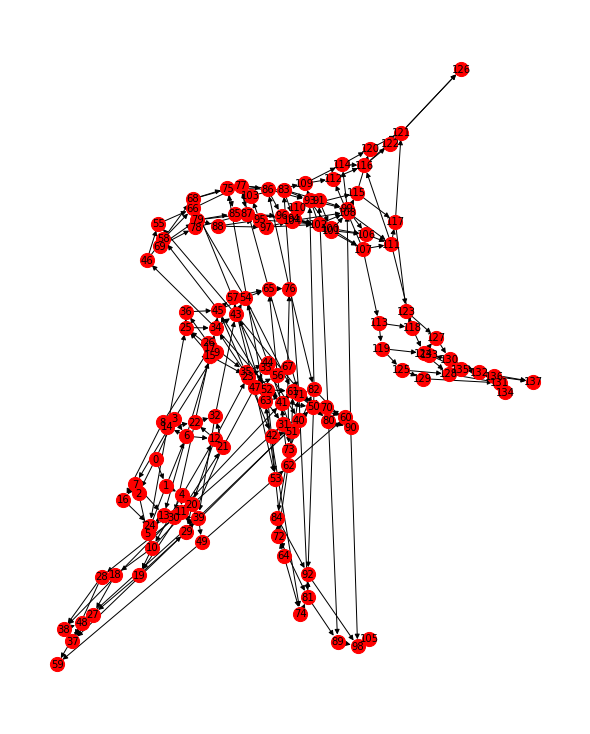

In [36]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt 
from torch_geometric.data import Data

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.__mat_pre=mat_pre
        self.__mat_post=mat_post
        self.__mat=self.__mat_post-self.__mat_pre
        self.m=m0

    def get_tansition(self,M):  
        self.Te=(M[:,None]>=self.__mat_pre).all(0).nonzero()[0]
        return self.Te
        
    def is_empty_Te(self):
        return  np.where(len(self.Te),True,False)

    def firing(self,M,T):
        self.m=M+self.__mat[:,T] 
        return self.m

    @classmethod
    def mat_imput(cls,mat_pre_path,mat_post_path,m0_path):
        pre = np.loadtxt(mat_pre_path,dtype=int)
        post = np.loadtxt(mat_post_path,dtype=int)
        m0 = np.loadtxt(m0_path,dtype=int) 
        return cls(pre,post,m0)

class Petri_net_to_graph(Petri_net):
    def __init__(self,mat_pre,mat_post,m0):
        super().__init__(mat_pre,mat_post,m0)
        self.Vnew=np.array([m0])

    def is_empty_Vnew(self):  ##判断Vnew是否为空
        return np.where(len(self.Vnew),True,False)

    def Vnew_delete(self,): ##从Vnew删除选择节点
        self.Vnew=np.delete(self.Vnew,0,axis=0)

    def T_delete(self,t):     ##并从Te中删除
        self.Te=np.delete(self.Te,0,axis=0)

    def node_choose(self):    ##从Vnew选择新节点
        temp=self.Vnew[0]
        return temp

    def Te_choose(self):    ##从Te选择一个可激发变迁
        temp=self.Te[0]
        return temp

    def is_new_node(self,V,m_new):  ##判断新节点是否在V中出现过
        temp=self.compare(V,m_new)
        return np.where(temp.size,False,True)

    def append_vnew(self,m):
        self.Vnew=np.append(self.Vnew,m.reshape(1,-1),axis=0)

    def compare(self,x,y):
        return (x==y[:None]).all(1).nonzero()[0]

class Graph_reachable(object):
    def __init__(self,m0):
        self.node=np.array([m0])
        self.edge = np.array([[],[]],dtype=int)
        self.weigh=np.array([],dtype=int)
        self.node_num=1
        self.lable=np.array([self.node_num-1],dtype=int)
        self.adj_list = {0:[]}

    def append_node(self,m):
        self.node_num=self.node_num+1
        self.lable=np.append(self.lable,[self.node_num-1],axis=0)
        self.node=np.append(self.node,m.reshape(1,-1),axis=0)

    def append_edge(self,head_node,next_node):
        edge=np.append(head_node.reshape(1,-1),next_node.reshape(1,-1),axis=0)
        self.edge=np.append(self.edge,edge,axis=1)

    def append_weigh(self,t):
        self.weigh=np.append(self.weigh,np.array([t]),axis=0)

    def append_head_node(self,head_node):
        self.adj_list.update({head_node[0]:[]})

    def append_next_node(self,head_node, node_name):
        self.adj_list[head_node[0]].append(node_name[0])

    def data_into_graph(self):
        self.weigh=np.append(self.edge,self.weigh.reshape(1,-1),axis=0)
        graph_dict = {
            'node':self.node,
            'edge_index': self.edge.transpose(),
            'weight': self.weigh.transpose(),
            'lable': self.lable,
            'num_nodes': self.node_num,
            #'adj_list':self.adj_list
        }
        return Data.from_dict(graph_dict)
pos = {
        0:(0,0),
        1:(0.5,-1),
        2:(-0.5,-1),
        3:(1,-2),
        4:(0,-2),
        5:(-1,-2),
        6:(0.5,-3),
        7:(1.5,-3),
        8:(-0.5,-3),
        9:(2,-4),
        10:(1,-4),
        11:(0,-4),
        12:(2.5,-5),
        13:(1.5,-5),
        14:(0.5,-5),
        15:(-0.5,-5),
        16:(1,-6),
        17:(2,-6),
        18:(0,-6),
        19:(-1,-6),
        20:(1.5,-7),
        21:(-0.5,-7),
        22:(-1.5,-7),
        23:(-1,-8),
        24:(-2,-8),
        25:(-1.5,-9),
        26:(-0.5,-9),
        27:(-2.5,-9),
        28:(-1,-10),
        29:(-3,-10),
        30:(-3.5,-11)
        }

net_to_graph=Petri_net_to_graph.mat_imput("c.pre.txt","c.post.txt","m0.txt")
graph=Graph_reachable(net_to_graph.m)
G = nx.DiGraph()
while(net_to_graph.is_empty_Vnew()):                                #       判断Vnew是否为空  进入第一层循环
    new_node=net_to_graph.node_choose()                             #步骤4  从Vnew中选取新节点m
    net_to_graph.Te=net_to_graph.get_tansition(new_node)            #步骤5  获得m可激发变迁Te
    head_node=net_to_graph.compare(graph.node,new_node)
    net_to_graph.Vnew_delete()                                      #       并删除Vnew
    graph.append_head_node(head_node)                              
    while(net_to_graph.is_empty_Te()):                              #       判断Te是否为空    进入第二层循环
        tran=net_to_graph.Te_choose()                               #步骤6  从Te中选择一个可激发变迁
        net_to_graph.T_delete(tran)                                 #       并将该变迁从Te中删除
        net_to_graph.m=net_to_graph.firing(new_node,tran)           #步骤7  激发变迁  得到m'
        if net_to_graph.is_new_node(graph.node,net_to_graph.m):     #步骤8  判断m'是不是新出现节点                                        
            net_to_graph.append_vnew(net_to_graph.m)                #       是  则更新V_new  V 
            graph.append_node(net_to_graph.m)                       #       更新V      
        next_node=net_to_graph.compare(graph.node,net_to_graph.m)
        graph.append_next_node(head_node,next_node)
        graph.append_edge(head_node,next_node)                      #       更新E
        graph.append_weigh(tran)                                    #       更新W 

graph_data=graph.data_into_graph()
print(graph_data)

G.add_edges_from(graph.edge.transpose())
plt.figure(figsize=(8,10))
pos = nx.spring_layout(G, seed=3)
nx.draw(G,pos=pos,node_color='red',edge_color='black',
          with_labels=True,font_size =10,node_size =200)
plt.show()

In [37]:
graph.adj_list

{0: [1, 2, 3],
 1: [4, 5, 6],
 2: [5, 7],
 3: [6, 7, 8, 9],
 4: [10, 11, 12],
 5: [10, 13],
 6: [12, 13, 14, 15],
 7: [13, 16],
 8: [14, 16, 17],
 9: [15, 17],
 10: [18, 19, 20],
 11: [19, 21],
 12: [20, 21, 22, 23],
 13: [20, 24],
 14: [22, 24, 25],
 15: [26, 23, 25],
 16: [24],
 17: [25],
 18: [27, 28],
 19: [27, 29],
 20: [28, 29, 30, 31],
 21: [29, 32, 33],
 22: [30, 32, 34],
 23: [35, 31, 33, 34],
 24: [30],
 25: [36, 34],
 26: [35, 36],
 27: [37],
 28: [37, 38],
 29: [37, 39, 40],
 30: [38, 39, 41],
 31: [42, 40, 41],
 32: [39, 43],
 33: [44, 40, 43],
 34: [45, 41, 43, 46],
 35: [47, 42, 44, 45],
 36: [45],
 37: [48],
 38: [48],
 39: [48, 49, 50],
 40: [51, 50],
 41: [52, 50],
 42: [53, 51, 52],
 43: [54, 50, 55],
 44: [56, 51, 54],
 45: [57, 52, 54, 58],
 46: [58, 55],
 47: [53, 56, 57],
 48: [59],
 49: [59, 60],
 50: [61, 60],
 51: [62, 61],
 52: [63, 61],
 53: [64, 62, 63],
 54: [65, 61, 66],
 55: [66],
 56: [62, 67, 65],
 57: [63, 65, 68],
 58: [69, 68, 66],
 59: [],
 60: [70

In [8]:
graph_data.edge_index,graph_data.lable,graph_data.node,graph_data.weight

(array([[ 0,  1],
        [ 0,  2],
        [ 1,  3],
        [ 1,  4],
        [ 2,  4],
        [ 2,  5],
        [ 3,  6],
        [ 3,  7],
        [ 4,  6],
        [ 4,  8],
        [ 5,  8],
        [ 6,  9],
        [ 6, 10],
        [ 6, 11],
        [ 7, 10],
        [ 8, 11],
        [ 9, 12],
        [ 9, 13],
        [10, 12],
        [10, 14],
        [11, 13],
        [11, 14],
        [11, 15],
        [12, 16],
        [13, 16],
        [13, 17],
        [14, 16],
        [14, 18],
        [15, 19],
        [15, 18],
        [16, 20],
        [17, 20],
        [18, 21],
        [19, 22],
        [19, 21],
        [21, 23],
        [22, 24],
        [22, 23],
        [23, 25],
        [23, 26],
        [24, 25],
        [24, 27],
        [25, 28],
        [25, 29],
        [26, 28],
        [27, 29],
        [28, 30],
        [29, 30]], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 2

In [18]:
from node2vec import Node2Vec

In [38]:
node2vec = Node2Vec(G, 
                    dimensions=32,  # 嵌入维度
                    p=1,            # 回家参数
                    q=2,          # 外出参数
                    walk_length=10, # 随机游走最大长度
                    num_walks=600,  # 每个节点作为起始节点生成的随机游走个数
                    workers=4       # 并行线程数
                   )

Computing transition probabilities: 100%|██████████| 138/138 [00:00<00:00, 5749.22it/s]


In [39]:
model = node2vec.fit(window=3,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )

In [40]:
X = model.wv.vectors

In [45]:
model.wv.most_similar('3')

[('0', 0.7823112607002258),
 ('1', 0.7520200610160828),
 ('2', 0.712483823299408),
 ('38', 0.6163062453269958),
 ('8', 0.5751577019691467),
 ('9', 0.5711944103240967),
 ('6', 0.5657545924186707),
 ('48', 0.5407390594482422),
 ('58', 0.52146315574646),
 ('46', 0.5196097493171692)]